# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109B Data Science 2: Advanced Topics in Data Science 
## Lab 8 - Bayesian Analysis, Part 1 - JAGS (+RL setup)



**Harvard University**<br/>
**Spring 2019**<br/>
**Instructors**: Mark Glickman and Pavlos Protopapas 


<hr style="height:2pt">

Note that this lab has been tested with 
* pandas version 0.22.0
* rpy2 version 2.9.4

The latest libraries may have changed somewhat since these versions; if you are having problems, try using these versions.

In this lab, we are working with JAGS, so make sure that it is installed on your system.

In [2]:
import os
os.environ['R_HOME'] = "/usr/share/anaconda3/lib/R"

In [3]:
import pyjags
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline 

import pandas as pd
import rpy2

from rpy2.robjects.packages import importr
#If there are errors about missing R packages, run the code below:
# r_utils = importr("utils")
# r_utils.install_packages('coda')
r_coda = importr("coda")

from rpy2.robjects import pandas2ri
pandas2ri.activate()

## Example 1: A Bayesian Coin Flip

**The idea here is to use JAGS to estimate how fair a coin is, based on 100 coin flips.**

**Note:** `Markov Chain Monte Carlo (MCMC)` is something you need to find summary from a posterior distribution. How you observe the data, how you model your prior beliefs is all independent of the MCMC simulations. So in this case, we don't know how unfair this coin is. So we start with a theta (`init_theta`) and using that information and using Bayes' rule we can construct a likelihood function -- which is saying, **what's the likelihood that the observed data occurs if the value of theta is `init_theta`.** 

So we multiply `theta` by the true values over all the data points to get the likelihood function. Example, lets say we have 100 samples, 

**Observed Data:** *H, T, H, H,......100* 

**Likelihood Function:** $\theta$ x $(1-\theta)$ x $\theta$ x $\theta$..... = $\theta^{1/H}$ x $(1-\theta)^{1/T}$

where, H and T are number of Heads and Tails

This is also known as a `Beta Function`, which in this case can be defined as: $\beta(a, b)$ = $\theta^{a}$ x $(1-\theta)^{b}$ (Mean = a/(a+b))

However, the `Beta Function` is way more complicated for more complex problems with high dimensionality. And that's why we use `MCMC`.


In [5]:
coinflip_code = '''
model {
  for (i in 1:N){
    x[i] ~ dbern(theta)
  }
  theta ~ dunif(0,1)
}
'''

We pass our model to `pyjags` in the form of a string as mentioned above. Note that the prior beliefs ($\theta$) are encoded after the `model {}`.

In [22]:
#generate some data for our coin
coinflip_N = 100
true_theta = 0.6
coinflip_x = np.random.binomial(1, true_theta, coinflip_N)

In [23]:
init_theta = 0.5 #prior is that coin is fair
n_chains = 3

coinflip_model = pyjags.Model(coinflip_code, data=dict(x=coinflip_x, N=coinflip_N), init = dict(theta=init_theta), chains=n_chains)


In [24]:
coinflip_burnin = coinflip_model.sample(500, vars=['theta']) #warmup/burn-in
coinflip_samples = coinflip_model.sample(2500, vars=['theta'])


sampling: iterations 1500 of 1500, elapsed 0:00:00, remaining 0:00:00
sampling: iterations 7500 of 7500, elapsed 0:00:00, remaining 0:00:00


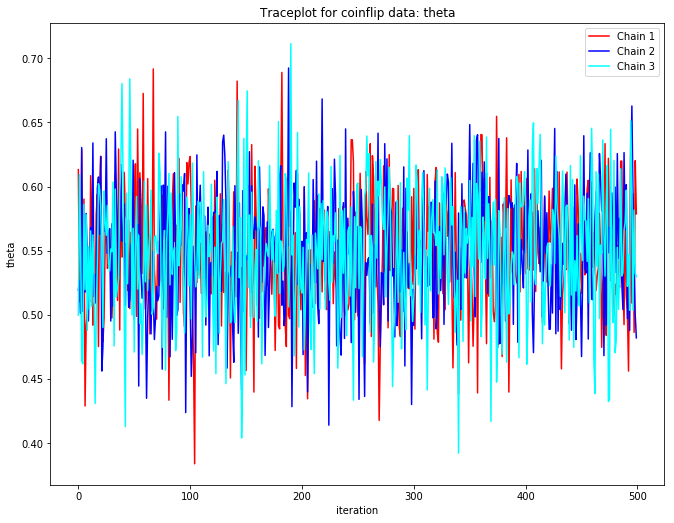

In [25]:
_ = plt.figure(figsize=(11,8.5))
_ = plt.plot(range(500),coinflip_burnin['theta'][0,:,0],color="red",label="Chain 1")
_ = plt.plot(range(500),coinflip_burnin['theta'][0,:,1],color="blue",label="Chain 2")
_ = plt.plot(range(500),coinflip_burnin['theta'][0,:,2],color="cyan",label="Chain 3")
_ = plt.xlabel("iteration")
_ = plt.ylabel("theta")
_ = plt.title("Traceplot for coinflip data: theta")
_ = plt.legend()

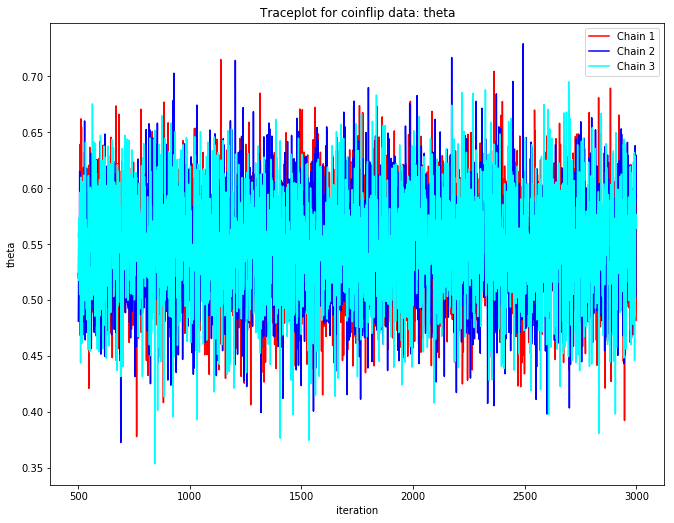

In [26]:
_ = plt.figure(figsize=(11,8.5))
_ = plt.plot(range(501,3001),coinflip_samples['theta'][0,:,0],color="red",label="Chain 1")
_ = plt.plot(range(501,3001),coinflip_samples['theta'][0,:,1],color="blue",label="Chain 2")
_ = plt.plot(range(501,3001),coinflip_samples['theta'][0,:,2],color="cyan",label="Chain 3")
_ = plt.xlabel("iteration")
_ = plt.ylabel("theta")
_ = plt.title("Traceplot for coinflip data: theta")
_ = plt.legend()

In [27]:
#chain 1
coinflip_chain1 = coinflip_samples['theta'][0][:,0]
coinflip_chain1_df = pd.DataFrame({'theta':coinflip_chain1})
coinflip_chain1_mcmc = r_coda.mcmc(pandas2ri.py2ri(coinflip_chain1_df))

#chain 2
coinflip_chain2 = coinflip_samples['theta'][0][:,1]
coinflip_chain2_df = pd.DataFrame({'theta':coinflip_chain2})
coinflip_chain2_mcmc = r_coda.mcmc(pandas2ri.py2ri(coinflip_chain2_df))

#chain 3
coinflip_chain3 = coinflip_samples['theta'][0][:,2]
coinflip_chain3_df = pd.DataFrame({'theta':coinflip_chain3})
coinflip_chain3_mcmc = r_coda.mcmc(pandas2ri.py2ri(coinflip_chain3_df))

#convert to mcmc_list object
coinflip_chains=r_coda.mcmc_list(coinflip_chain1_mcmc,coinflip_chain2_mcmc,coinflip_chain3_mcmc)

#get n_eff and Rhat
coinflip_n_eff = np.round(np.array(r_coda.effectiveSize(coinflip_chains))) #round because must be an integer
coinflip_rhat = np.array(r_coda.gelman_diag(coinflip_chains).rx2("psrf"))
coinflip_rhat = coinflip_rhat[0][0] #extract point estimates

#calculate summary
coinflip_theta_summary = [np.mean(coinflip_samples['theta']),np.std(coinflip_samples['theta'])]
for i in [0.025,0.25,0.5,0.75,0.975]:
    coinflip_theta_summary.append(np.quantile(coinflip_samples['theta'],i))
coinflip_theta_summary.append(coinflip_n_eff[0])
coinflip_theta_summary.append(coinflip_rhat)
coinflip_summary = pd.DataFrame([coinflip_theta_summary],columns=["mean","sd","2.5%","25%","50%","75%","97.5%","n_eff","Rhat"],index=["theta"])
coinflip_summary.round(3)

,mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
theta,0.549,0.048,0.453,0.516,0.549,0.582,0.643,7763.0,1.0


### Exercise:

Try running the analysis above with different values of $p$ (the probability of the coin), as well as with different values for N (number of coin flips in the data). What do you observe?

In [28]:
#try it here

## Example 2: Mean and Standard Deviation of the Normal

**Given samples from a normal distribution, we want to estimate its mean and standard deviation.**

In [29]:
normal_code = '''
model {
    for (i in 1:N){
    x[i] ~ dnorm(mu, tau)
    }
mu ~ dnorm(0,.0001)
tau = pow(sigma, -2)
sigma ~ dunif(0,100)
}
'''

In [30]:
#generate some data for our normal distribution
normal_N = 1000
true_mu = -5
true_sigma = 5
normal_x = np.random.normal(true_mu, true_sigma, 1000) #true data: mean = -5, standard deviation = 5

#prior is that this is a standard normal
init_mu = 0 
init_sigma = 1 

In [31]:

normal_model = pyjags.Model(normal_code, data=dict(x=normal_x, N=normal_N), init = dict(mu=init_mu, sigma=init_sigma),chains=3)
normal_burnin = normal_model.sample(500, vars=['mu','sigma']) #warmup/burn-in
normal_samples = normal_model.sample(2500, vars=['mu','sigma'])


adapting: iterations 3000 of 3000, elapsed 0:00:02, remaining 0:00:00
sampling: iterations 1500 of 1500, elapsed 0:00:01, remaining 0:00:00
sampling: iterations 7500 of 7500, elapsed 0:00:04, remaining 0:00:00


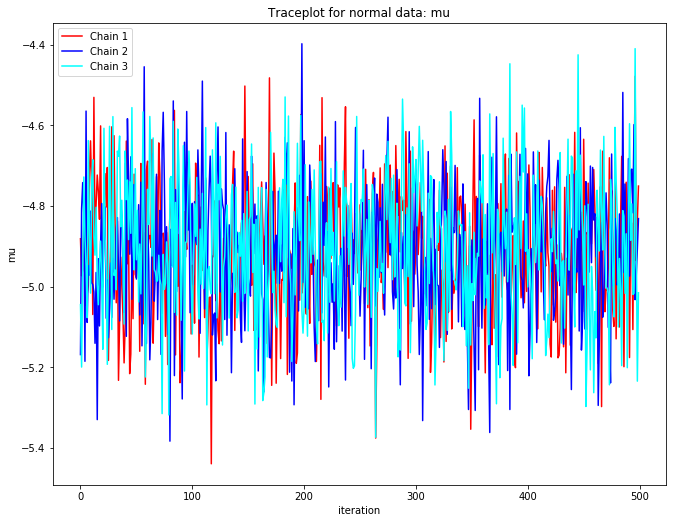

In [32]:
_ = plt.figure(figsize=(11,8.5))
_ = plt.plot(range(500),normal_burnin['mu'][0,:,0],color="red",label="Chain 1")
_ = plt.plot(range(500),normal_burnin['mu'][0,:,1],color="blue",label="Chain 2")
_ = plt.plot(range(500),normal_burnin['mu'][0,:,2],color="cyan",label="Chain 3")
_ = plt.xlabel("iteration")
_ = plt.ylabel("mu")
_ = plt.title("Traceplot for normal data: mu")
_ = plt.legend()

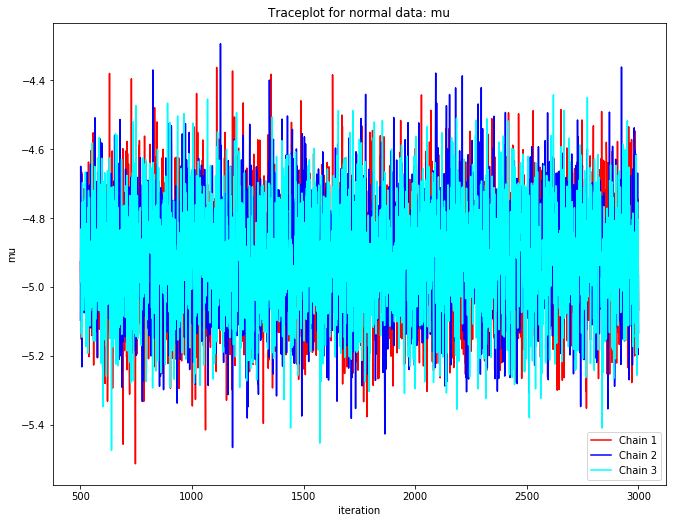

In [33]:
_ = plt.figure(figsize=(11,8.5))
_ = plt.plot(range(501,3001),normal_samples['mu'][0,:,0],color="red",label="Chain 1")
_ = plt.plot(range(501,3001),normal_samples['mu'][0,:,1],color="blue",label="Chain 2")
_ = plt.plot(range(501,3001),normal_samples['mu'][0,:,2],color="cyan",label="Chain 3")
_ = plt.xlabel("iteration")
_ = plt.ylabel("mu")
_ = plt.title("Traceplot for normal data: mu")
_ = plt.legend()

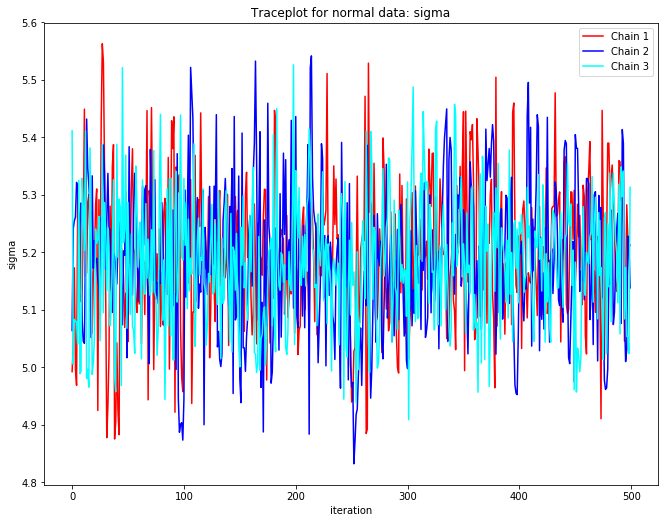

In [34]:
_ = plt.figure(figsize=(11,8.5))
_ = plt.plot(range(500),normal_burnin['sigma'][0,:,0],color="red",label="Chain 1")
_ = plt.plot(range(500),normal_burnin['sigma'][0,:,1],color="blue",label="Chain 2")
_ = plt.plot(range(500),normal_burnin['sigma'][0,:,2],color="cyan",label="Chain 3")
_ = plt.xlabel("iteration")
_ = plt.ylabel("sigma")
_ = plt.title("Traceplot for normal data: sigma")
_ = plt.legend()

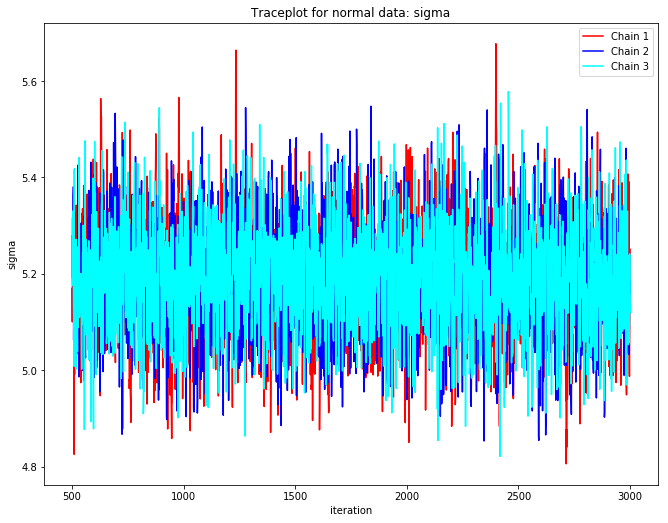

In [35]:
_ = plt.figure(figsize=(11,8.5))
_ = plt.plot(range(501,3001),normal_samples['sigma'][0,:,0],color="red",label="Chain 1")
_ = plt.plot(range(501,3001),normal_samples['sigma'][0,:,1],color="blue",label="Chain 2")
_ = plt.plot(range(501,3001),normal_samples['sigma'][0,:,2],color="cyan",label="Chain 3")
_ = plt.xlabel("iteration")
_ = plt.ylabel("sigma")
_ = plt.title("Traceplot for normal data: sigma")
_ = plt.legend()

In [36]:
#chain 1
normal_chain1 = np.column_stack((normal_samples['mu'][0][:,0],normal_samples['sigma'][0][:,0]))
normal_chain1_df = pd.DataFrame({'mu':normal_chain1[:,0],'sigma':normal_chain1[:,1]})
normal_chain1_mcmc = r_coda.mcmc(pandas2ri.py2ri(normal_chain1_df))
#chain 2
normal_chain2 = np.column_stack((normal_samples['mu'][0][:,1],normal_samples['sigma'][0][:,1]))
normal_chain2_df = pd.DataFrame({'mu':normal_chain2[:,0],'sigma':normal_chain2[:,1]})
normal_chain2_mcmc = r_coda.mcmc(pandas2ri.py2ri(normal_chain2_df))
#chain 3
normal_chain3 = np.column_stack((normal_samples['mu'][0][:,2],normal_samples['sigma'][0][:,2]))
normal_chain3_df = pd.DataFrame({'mu':normal_chain3[:,0],'sigma':normal_chain3[:,1]})
normal_chain3_mcmc = r_coda.mcmc(pandas2ri.py2ri(normal_chain3_df))
#convert to mcmc_list object
normal_chains=r_coda.mcmc_list(normal_chain1_mcmc,normal_chain2_mcmc,normal_chain3_mcmc)
#get n_eff and Rhat
normal_n_eff = np.round(np.array(r_coda.effectiveSize(normal_chains))) #round because must be an integer
normal_rhat = np.array(r_coda.gelman_diag(normal_chains).rx2("psrf"))
normal_rhat = np.array([normal_rhat[0][0],normal_rhat[1][0]]) #extract point estimates
#calculate summary
normal_mu_summary = [np.mean(normal_samples['mu']),np.std(normal_samples['mu'])]
normal_sigma_summary = [np.mean(normal_samples['sigma']),np.std(normal_samples['sigma'])]
for i in [0.025,0.25,0.5,0.75,0.975]:
    normal_mu_summary.append(np.quantile(normal_samples['mu'],i))
    normal_sigma_summary.append(np.quantile(normal_samples['sigma'],i))
normal_mu_summary.append(normal_n_eff[0])
normal_mu_summary.append(normal_rhat[0])
normal_sigma_summary.append(normal_n_eff[1])
normal_sigma_summary.append(normal_rhat[1])
normal_summary = pd.DataFrame([normal_mu_summary,normal_sigma_summary],columns=["mean","sd","2.5%","25%","50%","75%","97.5%","n_eff","Rhat"],index=["mu","sigma"])
normal_summary.round(3)

,mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
mu,-4.914,0.162,-5.232,-5.023,-4.913,-4.804,-4.598,7500.0,1.001
sigma,5.189,0.116,4.964,5.111,5.188,5.267,5.422,4850.0,1.000


### Exercise:

Try varying the length of the burn-in period and number of iterations in the chains. What do you observe?

In [37]:
#try it here

## Example 3: Linear Regression

**We will run a simple linear regression using JAGS.**

In [38]:
regression_code = '''
model {       
    for (i in 1:N){
        y[i] ~ dnorm(mu[i], tau)
        mu[i] = a + b * x[i]       
    }       
a ~ dnorm(0, .0001)       
b ~ dnorm(0, .0001)       
tau = pow(sigma, -2)       
sigma ~ dunif(0, 100)
}
'''

In [39]:
regression_N = 1000
true_b = 5
true_a = 70
regression_x = np.arange(1,1001)
regression_epsilon = np.random.normal(true_a,100,1000)
regression_y = true_b*regression_x + regression_epsilon
#prior is that y = x (i.e., a = 0, b = 1)
prior_a = 0
prior_b = 1

In [40]:
regression_model = pyjags.Model(regression_code, data=dict(x=regression_x, y=regression_y, N = regression_N), init = dict(a = prior_a, b = prior_b),chains=3)
regression_burnin = regression_model.sample(500, vars=['a','b']) #warmup/burn-in
regression_samples = regression_model.sample(2500, vars=['a','b'])

adapting: iterations 3000 of 3000, elapsed 0:00:02, remaining 0:00:00
sampling: iterations 1500 of 1500, elapsed 0:00:01, remaining 0:00:00
sampling: iterations 7500 of 7500, elapsed 0:00:05, remaining 0:00:00


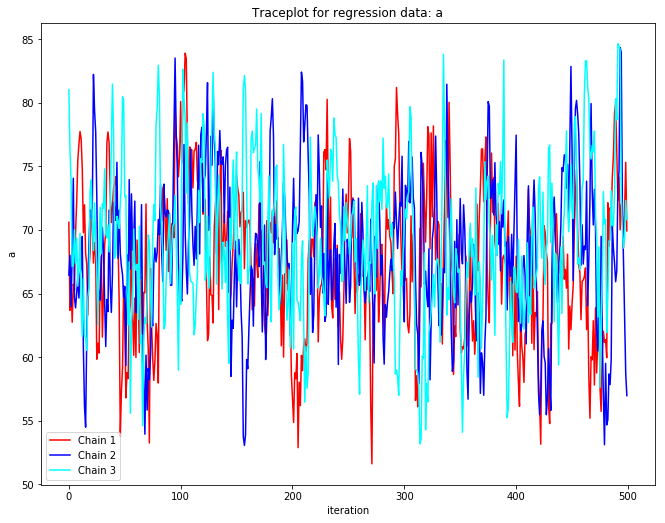

In [41]:
_ = plt.figure(figsize=(11,8.5))
_ = plt.plot(range(500),regression_burnin['a'][0,:,0],color="red",label="Chain 1")
_ = plt.plot(range(500),regression_burnin['a'][0,:,1],color="blue",label="Chain 2")
_ = plt.plot(range(500),regression_burnin['a'][0,:,2],color="cyan",label="Chain 3")
_ = plt.xlabel("iteration")
_ = plt.ylabel("a")
_ = plt.title("Traceplot for regression data: a")
_ = plt.legend()

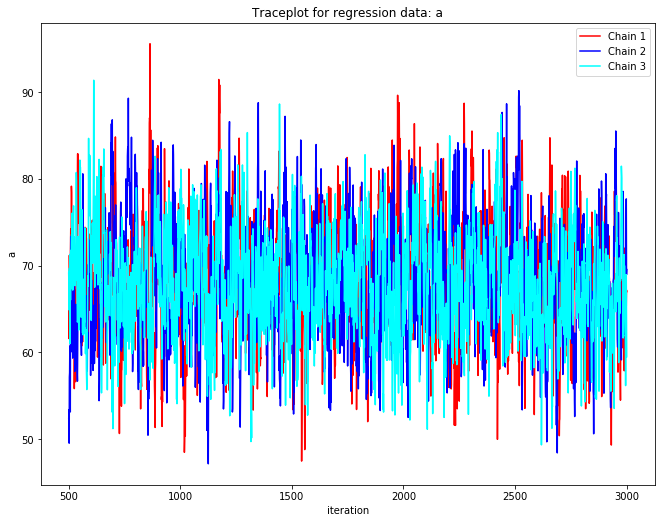

In [42]:
_ = plt.figure(figsize=(11,8.5))
_ = plt.plot(range(501,3001),regression_samples['a'][0,:,0],color="red",label="Chain 1")
_ = plt.plot(range(501,3001),regression_samples['a'][0,:,1],color="blue",label="Chain 2")
_ = plt.plot(range(501,3001),regression_samples['a'][0,:,2],color="cyan",label="Chain 3")
_ = plt.xlabel("iteration")
_ = plt.ylabel("a")
_ = plt.title("Traceplot for regression data: a")
_ = plt.legend()

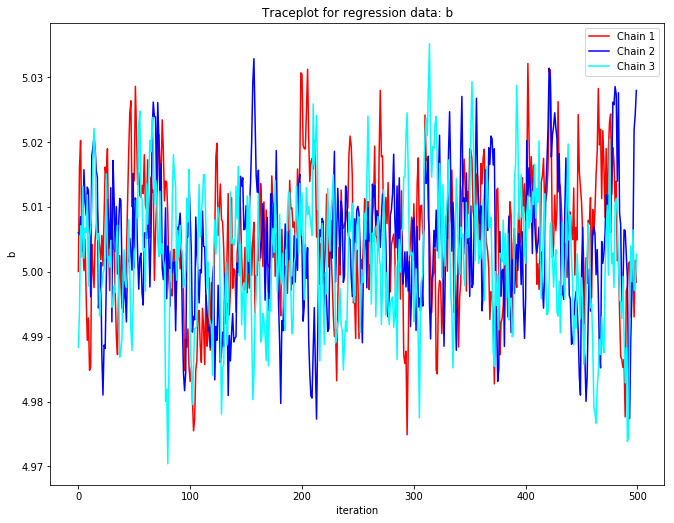

In [43]:
_ = plt.figure(figsize=(11,8.5))
_ = plt.plot(range(500),regression_burnin['b'][0,:,0],color="red",label="Chain 1")
_ = plt.plot(range(500),regression_burnin['b'][0,:,1],color="blue",label="Chain 2")
_ = plt.plot(range(500),regression_burnin['b'][0,:,2],color="cyan",label="Chain 3")
_ = plt.xlabel("iteration")
_ = plt.ylabel("b")
_ = plt.title("Traceplot for regression data: b")
_ = plt.legend()

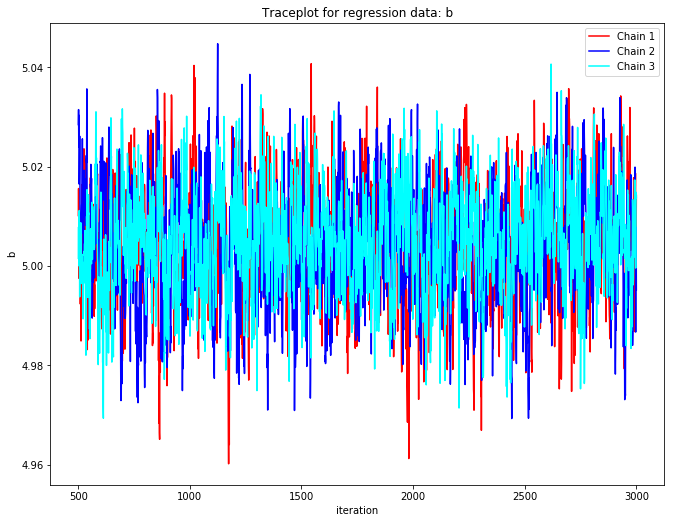

In [44]:
_ = plt.figure(figsize=(11,8.5))
_ = plt.plot(range(501,3001),regression_samples['b'][0,:,0],color="red",label="Chain 1")
_ = plt.plot(range(501,3001),regression_samples['b'][0,:,1],color="blue",label="Chain 2")
_ = plt.plot(range(501,3001),regression_samples['b'][0,:,2],color="cyan",label="Chain 3")
_ = plt.xlabel("iteration")
_ = plt.ylabel("b")
_ = plt.title("Traceplot for regression data: b")
_ = plt.legend()

In [45]:
#chain 1
regression_chain1 = np.column_stack((regression_samples['a'][0][:,0],regression_samples['b'][0][:,0]))
regression_chain1_df = pd.DataFrame({'a':regression_chain1[:,0],'b':regression_chain1[:,1]})
regression_chain1_mcmc = r_coda.mcmc(pandas2ri.py2ri(regression_chain1_df))

#chain 2
regression_chain2 = np.column_stack((regression_samples['a'][0][:,1],regression_samples['b'][0][:,1]))
regression_chain2_df = pd.DataFrame({'a':regression_chain2[:,0],'b':regression_chain2[:,1]})
regression_chain2_mcmc = r_coda.mcmc(pandas2ri.py2ri(regression_chain2_df))

#chain 3
regression_chain3 = np.column_stack((regression_samples['a'][0][:,2],regression_samples['b'][0][:,2]))
regression_chain3_df = pd.DataFrame({'a':regression_chain3[:,0],'b':regression_chain3[:,1]})
regression_chain3_mcmc = r_coda.mcmc(pandas2ri.py2ri(regression_chain3_df))

#convert to mcmc_list object
regression_chains=r_coda.mcmc_list(regression_chain1_mcmc,regression_chain2_mcmc,regression_chain3_mcmc)

#get n_eff and Rhat
regression_n_eff = np.round(np.array(r_coda.effectiveSize(regression_chains))) #round because must be an integer
regression_rhat = np.array(r_coda.gelman_diag(regression_chains).rx2("psrf"))
regression_rhat = np.array([regression_rhat[0][0],regression_rhat[1][0]]) #extract point estimates

#calculate summary
regression_a_summary = [np.mean(regression_samples['a']),np.std(regression_samples['a'])]
regression_b_summary = [np.mean(regression_samples['b']),np.std(regression_samples['b'])]
for i in [0.025,0.25,0.5,0.75,0.975]:
    regression_a_summary.append(np.quantile(regression_samples['a'],i))
    regression_b_summary.append(np.quantile(regression_samples['b'],i))
regression_a_summary.append(regression_n_eff[0])
regression_a_summary.append(regression_rhat[0])
regression_b_summary.append(regression_n_eff[1])
regression_b_summary.append(regression_rhat[1])
regression_summary = pd.DataFrame([regression_a_summary,regression_b_summary],columns=["mean","sd","2.5%","25%","50%","75%","97.5%","n_eff","Rhat"],index=["a","b"])
regression_summary.round(3)

,mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
a,68.138,6.454,55.724,63.749,68.079,72.401,81.170,1029.0,1.004
b,5.004,0.011,4.982,4.997,5.005,5.012,5.026,1020.0,1.003


### Exercise:

Compare the results of performing a linear regression with this method and a non-Bayesian approach (say, using the sklearn LinearRegression function). What do you observe?

In [46]:
#try it here


**A reflection on lab-8**

**Student's Note:**
Hi class, I did not follow lab-8 very well yesterday. When I came back, I thought about it and would like to share my reflection with those had similar puzzles.

The goal of lab-8 is to extract model parameters for a user-defined model and provided data. The process goes in four steps:
1. Define the model, e.g., x ~ N(0,s) and s ~ N(0,0.01). 
2. Provide the data, e.g., [x1, x2, ...]
3. Run MCMC to extract model parameters, i.e., the time series s(t).
4. Summarize the results, i.e., calculating s = and other statistical properties.

How does MCMC work in the step-3?
1. The model parameter distribution, p(s), and the likelihood, p(x|s), are known.
2. Using the Bayes rule, the posterior is p(s|x) ~ p(x|s) * p(s) (up to a normalization factor). p(s|data) = prod_{x} p(x|s)
3. In principle, can be calculated by = integrate s * p(s|data) * ds, which can be done with Monte Carlo numerically.
4. An alternatively way of computing is to use Markov chain
4.1 make an initial guess: s = s0
4.2 calculate the transition rate from s to s' according to the ratio p(s'|data) / p(s|data)
4.3 do one time evolution using a random number
4.4 run many time steps until s(t) is fully converged
5. The equivalence between 3 and 4 is backed by the ergodic theory.

**Instructor's Response:**

The overall goal is to take
1. data

2. a story about where the data came from, involving certain parameters [P(Data=observed data | Parameters=y), for any value of y] (aka the Likelihood)

3. our current (aka prior) belief about what the parameters are [P(Parameters = x), for any value of x] and 

4. produce a report on how plausible each particular set of parameter values is [P(Parameters=z), for any value of z] (aka the Posterior)

We don't get (or want!) a single final answer. We want a full description of "Look, the parameter theta might be .5, it might also be .6, but .5 is more likely, and it's definitely not .7, ...". The basic shift from frequentest to bayes is that bayesians add additional facts/assumptions (the prior) and therefore get a richer result. (And it's fine if you're not comfortable adding those facts/assumptions)

Anyway, mathematically, 2) is a function and 3) is a function and 4) is those functions multiplied together with a supernaturally ugly integral in the denominator. So the challenge is to extract any kind of information from 4) without actually knowing its exact value at any point.

Enter MCMC. Basically, its purpose is to produce a dataset of values which collectively have a given histogram. You give it a function, it gives you a dataset whose histogram closely matches that function*. Equivalently, it produces a dataset (e.g. of parameter values), where how common/likely a given parameter value is will be reflected in how many times that value appears in the dataset. Importantly, it works without knowing the value of that ugly denominator.

So, MCMC spits out a slightly reworked version of 4)!!! It isn't mathematically precise since it's just sample data, but we can still learn a ton. Want to know P(x>7)? Count the percentage of rows where x>7! Want to know P(y=3 but x!=3)? Count the percentage of rows where y=3 but x!=3! Want to know the mean value of x? Just calculate the mean in the dataset. You get the picture. It's gloriously simple.

*terms and conditions apply to MCMC.* It takes time to warm up, and it may not always produce a good sample. We do diagnostic checks to make sure nothing looks obviously wrong before analyzing the results. Accuracy depends on the number of MCMC samples we have (that is, how long we run MCMC) and what aspect of the posterior we're trying to view. Running more MCMC will give us a clearer view of the posterior, but won't make up for a lack of data-- we'd see with high precision that the posterior is spread across lots of possible parameter values.

 In terms of the software,

2) and 3) are written out as a literal story in the JAGS langauge. There's lots of lines like "x[i] ~ Binomial(N,theta)", which (translated) says the ith entry of the x vector was drawn from a Binomial distribution with parameters N and theta. Which, translated again, says "the ith entry of X is the number of times a coin with bias=theta came up heads in N flips". See? Stories about the data.

So that tells us how the observed data came to be. But since theta isn't defined yet, we'd go on to specify how theta arose; it's drawn from a uniform(0,1). 0 and 1 are both well-defined so we're done with the story! Time to run pyjags, get back that parameter-dataset, and analyze it.

If translating "binomial" to "coin flips" or vice versa isn't your strong suit, plan to visit OHs during HW 6-- this is a language that's very useful to speak. You can also try to look up various phrase books (Our own Joe Blitzstien is awesome for this).

## Example 4: Reinforcement Learning with Open AI Gym

In this lab we are going to work with OpenAIgym's FrozenLake environment. The details of the environment can be found in the link https://gym.openai.com/envs/FrozenLake-v0/. 


Winter is here. You and your friends were tossing around a frisbee at the park when you made a wild throw that left the frisbee out in the middle of the lake. The water is mostly frozen, but there are a few holes where the ice has melted. If you step into one of those holes, you'll fall into the freezing water. At this time, there's an international frisbee shortage, so it's absolutely imperative that you navigate across the lake and retrieve the disc. 

The agent controls the movement of a character in a grid world. Some tiles of the grid are walkable, and others lead to the agent falling into the water. Additionally, the movement direction of the agent is uncertain and only partially depends on the chosen direction. The agent is rewarded for finding a walkable path to a goal tile.

The surface is described using a grid like the following:
[PP: WOULD IT BETTER TO INCLUDE A DIAGRAM]

- S: starting point, safe
- F: frozen surface, safe
- H: hole, fall to your doom
- G: goal, where the frisbee is located

SFFF  <br> 
FHFH <br> 
FFFH  <br> 
HFFG <br> 

Expected actions are Left(0), Right(1), Down(2), Up(3). 

The episode ends when you reach the goal or fall in a hole. You receive a reward of 1 if you reach the goal, and zero otherwise.


In [4]:
import gym
from gym.envs.registration import register
register(id='FrozenLakeNotSlippery-v0',
    entry_point='gym.envs.toy_text:FrozenLakeEnv',
    kwargs={'map_name' : '4x4', 'is_slippery': False},
    max_episode_steps=100,
    reward_threshold=0.8196, # optimum = .8196
)

In [5]:
from gym.envs.registration import register
register(
    id='FrozenLake8x8NotSlippery-v0',
    entry_point='gym.envs.toy_text:FrozenLakeEnv',
    kwargs={'map_name' : '8x8', 'is_slippery': False},
    max_episode_steps=100,
    reward_threshold=0.8196, # optimum = .8196
)

*hint:* If you receive an error message while registering the above env the second time you run this cell again, ignore the error message or restart the kernel. 

Throughout the assignment, use only the environments we registered in the previous cells:
- `FrozenLake8x8NotSlippery-v0`
- `FrozenLakeNotSlippery-v0` 

Even though the original problem description has slippery environment, we are working in a non-slippery environment. In our environment, if you go right, you only go right whereas in the original environment, if you intend to go right, you can go right, up or down with 1/3 probability.



In [6]:
import gym
import numpy as np

#Change environment to FrozenLake8x8 to see grid.
env = gym.make('FrozenLake-v0')
#env = gym.make('FrozenLake8x8NotSlippery-v0')

print(env.observation_space.n)


#Both the grids look like as follows.
'''
    "4x4": [
        "SFFF",
        "FHFH",
        "FFFH",
        "HFFG"
    ],
    "8x8": [
        "SFFFFFFF",
        "FFFFFFFF",
        "FFFHFFFF",
        "FFFFFHFF",
        "FFFHFFFF",
        "FHHFFFHF",
        "FHFFHFHF",
        "FFFHFFFG"
    ]'''

#env.render() prints the frozenlake with an indicator showing where the agent is. You can use it for debugging.
env.render()

16

SFFF
FHFH
FFFH
HFFG


In [7]:
print(env.observation_space.n)
print(env.action_space.n)

16
4


In [8]:
Q = np.zeros([env.observation_space.n,env.action_space.n])

def choose_action(state):
    return np.random.choice(np.array([0,1,2,3]))

def learn(s, s1, r, a):
    return

In [9]:
# Set learning parameters
################

# num_episodes = 2000
# epsilon = 0.0
# max_steps = 100
# lr_rate = 0.0
# gamma = 0.0
# rList = []

num_episodes = 10
max_iter_per_episode = 20
for i in range(num_episodes):
    iter = 0
            
    #Reset environment and get an initial state - should be done at start of each episode.
    s = env.reset()
    rAll = 0
    d = False
    j = 0
    while iter < max_iter_per_episode:
        iter+=1
        #Choose an action
        a = choose_action(s)
        # env.step() gives you next state, reward, done(whether the episode is over)
        # s1 - new state, r-reward, d-whether you are done or not
        s1,r,d,_ = env.step(a)
        print('State : ',s, ' Action : ', a, ' State 1 : ', s1, ' Reward : ',r, 'Done : ', d)
        
        learn(s, s1, r, a)
        
        if d:
            print('Episode Over')
            if r != 1:
                print('Fell into hole with reward ', r)            
            break
        s = s1
    if r==1:
        print(i)
        break

State :  0  Action :  1  State 1 :  4  Reward :  0.0 Done :  False
State :  4  Action :  1  State 1 :  5  Reward :  0.0 Done :  True
Episode Over
Fell into hole with reward  0.0
State :  0  Action :  3  State 1 :  0  Reward :  0.0 Done :  False
State :  0  Action :  0  State 1 :  0  Reward :  0.0 Done :  False
State :  0  Action :  1  State 1 :  1  Reward :  0.0 Done :  False
State :  1  Action :  2  State 1 :  5  Reward :  0.0 Done :  True
Episode Over
Fell into hole with reward  0.0
State :  0  Action :  3  State 1 :  0  Reward :  0.0 Done :  False
State :  0  Action :  1  State 1 :  4  Reward :  0.0 Done :  False
State :  4  Action :  3  State 1 :  5  Reward :  0.0 Done :  True
Episode Over
Fell into hole with reward  0.0
State :  0  Action :  0  State 1 :  4  Reward :  0.0 Done :  False
State :  4  Action :  3  State 1 :  0  Reward :  0.0 Done :  False
State :  0  Action :  1  State 1 :  4  Reward :  0.0 Done :  False
State :  4  Action :  2  State 1 :  5  Reward :  0.0 Done :  Tru

In [10]:
env.reset()
env.step(1)

(1, 0.0, False, {'prob': 0.3333333333333333})

### Value Iteration Sample Code 
(https://github.com/dennybritz/reinforcement-learning/blob/master/DP/Value%20Iteration%20Solution.ipynb)

In [12]:
display(env.action_space.n)
display(env.observation_space.n)
display(env.reward_range)
display(env.env.P[s][a])

4

16

(0, 1)

[(0.3333333333333333, 0, 0.0, False),
 (0.3333333333333333, 5, 0.0, True),
 (0.3333333333333333, 2, 0.0, False)]

In [30]:
def one_step_lookahead(env, state, V, discount_factor=1.0):
    """
    Helper function to calculate the value for all action in a given state.

    Args:
        state: The state to consider (int)
        V: The value to use as an estimator, Vector of length env.nS

    Rreward_rangeeturns:
        A vector of length env.nA containing the expected value of each action.
    """
    A = np.zeros(env.env.nA)
    for a in range(env.env.nA):
        for prob, next_state, reward, done in env.env.P[state][a]:
            A[a] += prob*(reward + discount_factor * V[next_state])
    return A

In [31]:
def value_iteration(env, theta=0.0001):
    """
    Value Iteration Algorithm.
    
    Args:
        env: OpenAI env. env.P represents the transition probabilities of the environment.
            env.P[s][a] is a list of transition tuples (prob, next_state, reward, done).
            env.nS is a number of states in the environment. 
            env.nA is a number of actions in the environment.
        theta: We stop evaluation once our value function change is less than theta for all states.
        discount_factor: Gamma discount factor.
        
    Returns:
        A tuple (policy, V) of the optimal policy and the optimal value function.
    """
    
    
    V = np.zeros(env.env.nS)
    while True:
        # Stopping condition
        delta = 0
        # Update each state...
        for s in range(env.env.nS):
            # Do a one-step lookahead to find the best action
            A = one_step_lookahead(env, s, V)
            best_action_value = np.max(A)
            # Calculate delta across all states seen so far
            delta = max(delta, np.abs(best_action_value - V[s]))
            # Update the value function. Ref: Sutton book eq. 4.10. 
            V[s] = best_action_value        
        # Check if we can stop 
        if delta < theta:
            break
    
    # Create a deterministic policy using the optimal value function
    policy = np.zeros([env.env.nS, env.env.nA])
    for s in range(env.env.nS):
        # One step lookahead to find the best action for this state
        A = one_step_lookahead(env, s, V)
        best_action = np.argmax(A)
        # Always take the best action
        policy[s, best_action] = 1.0
    
    return policy, V

In [32]:
policy, v = value_iteration(env)

print("Policy Probability Distribution:")
print(policy)
print("")

print("Environment")
print(env.render())
print("")

print("Reshaped Grid Policy (0=Left, 1=Down, 2=Right, 3=Up):")
print(np.reshape(np.argmax(policy, axis=1), (env.env.nrow, env.env.ncol)))
print("")

print("Value Function:")
print(v)
print("")

print("Reshaped Grid Value Function:")
print(v.reshape(env.env.nrow, env.env.ncol))
print("")

Policy Probability Distribution:
[[1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]]

Environment
  (Down)
SFFF
FHFH
FFFH
HFFG
None

Reshaped Grid Policy (0=Left, 1=Down, 2=Right, 3=Up):
[[0 3 3 3]
 [0 0 0 0]
 [3 1 0 0]
 [0 2 1 0]]

Value Function:
[0.82182145 0.82126109 0.82087163 0.82067347 0.82199325 0.
 0.52824715 0.         0.82226231 0.82260733 0.76389785 0.
 0.         0.88171208 0.94085038 0.        ]

Reshaped Grid Value Function:
[[0.82182145 0.82126109 0.82087163 0.82067347]
 [0.82199325 0.         0.52824715 0.        ]
 [0.82226231 0.82260733 0.76389785 0.        ]
 [0.         0.88171208 0.94085038 0.        ]]



In [28]:
# Test the value function
expected_v = np.array([ 0, -1, -2, -3, -1, -2, -3, -2, -2, -3, -2, -1, -3, -2, -1,  0])
np.testing.assert_array_almost_equal(v, expected_v, decimal=2)

AssertionError: 
Arrays are not almost equal to 2 decimals

(mismatch 93.75%)
 x: array([0.82, 0.82, 0.82, 0.82, 0.82, 0.  , 0.53, 0.  , 0.82, 0.82, 0.76,
       0.  , 0.  , 0.88, 0.94, 0.  ])
 y: array([ 0, -1, -2, -3, -1, -2, -3, -2, -2, -3, -2, -1, -3, -2, -1,  0])

### Policy Iteration Sample Code
(https://github.com/dennybritz/reinforcement-learning/blob/master/DP/Policy%20Iteration%20Solution.ipynb)

In [41]:
def policy_eval(policy, env, discount_factor=1.0, theta=0.00001):
    """
    Evaluate a policy given an environment and a full description of the environment's dynamics.
    
    Args:
        policy: [S, A] shaped matrix representing the policy.
        env: OpenAI env. env.P represents the transition probabilities of the environment.
            env.P[s][a] is a list of transition tuples (prob, next_state, reward, done).
            env.nS is a number of states in the environment. 
            env.nA is a number of actions in the environment.
        theta: We stop evaluation once our value function change is less than theta for all states.
        discount_factor: Gamma discount factor.
    
    Returns:
        Vector of length env.nS representing the value function.
    """
    # Start with a random (all 0) value function
    V = np.zeros(env.nS)
    while True:
        delta = 0
        # For each state, perform a "full backup"
        for s in range(env.nS):
            v = 0
            # Look at the possible next actions
            for a, action_prob in enumerate(policy[s]):
                # For each action, look at the possible next states...
                for  prob, next_state, reward, done in env.P[s][a]:
                    # Calculate the expected value
                    v += action_prob * prob * (reward + discount_factor * V[next_state])
            # How much our value function changed (across any states)
            delta = max(delta, np.abs(v - V[s]))
            V[s] = v
        # Stop evaluating once our value function change is below a threshold
        if delta < theta:
            break
    return np.array(V)

In [42]:
def policy_improvement(env, policy_eval_fn=policy_eval, discount_factor=1.0):
    """
    Policy Improvement Algorithm. Iteratively evaluates and improves a policy
    until an optimal policy is found.
    
    Args:
        env: The OpenAI envrionment.
        policy_eval_fn: Policy Evaluation function that takes 3 arguments:
            policy, env, discount_factor.
        discount_factor: gamma discount factor.
        
    Returns:
        A tuple (policy, V). 
        policy is the optimal policy, a matrix of shape [S, A] where each state s
        contains a valid probability distribution over actions.
        V is the value function for the optimal policy.
        
    """

    def one_step_lookahead(state, V):
        """
        Helper function to calculate the value for all action in a given state.
        
        Args:
            state: The state to consider (int)
            V: The value to use as an estimator, Vector of length env.nS
        
        Returns:
            A vector of length env.nA containing the expected value of each action.
        """
        A = np.zeros(env.nA)
        for a in range(env.nA):
            for prob, next_state, reward, done in env.P[state][a]:
                A[a] += prob * (reward + discount_factor * V[next_state])
        return A
    
    # Start with a random policy
    policy = np.ones([env.nS, env.nA]) / env.nA
    
    while True:
        # Evaluate the current policy
        V = policy_eval_fn(policy, env, discount_factor)
        
        # Will be set to false if we make any changes to the policy
        policy_stable = True
        
        # For each state...
        for s in range(env.nS):
            # The best action we would take under the currect policy
            chosen_a = np.argmax(policy[s])
            
            # Find the best action by one-step lookahead
            # Ties are resolved arbitarily
            action_values = one_step_lookahead(s, V)
            best_a = np.argmax(action_values)
            
            # Greedily update the policy
            if chosen_a != best_a:
                policy_stable = False
            policy[s] = np.eye(env.nA)[best_a]
        
        # If the policy is stable we've found an optimal policy. Return it
        if policy_stable:
            return policy, V

In [43]:
policy, v = policy_improvement(env)
print("Policy Probability Distribution:")
print(policy)
print("")

print("Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):")
print(np.reshape(np.argmax(policy, axis=1), env.shape))
print("")

print("Value Function:")
print(v)
print("")

print("Reshaped Grid Value Function:")
print(v.reshape(env.shape))
print("")

Policy Probability Distribution:
[[1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]]

Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):


AttributeError: 'FrozenLakeEnv' object has no attribute 'shape'

In [ ]:
# Test the value function
expected_v = np.array([ 0, -1, -2, -3, -1, -2, -3, -2, -2, -3, -2, -1, -3, -2, -1,  0])
np.testing.assert_array_almost_equal(v, expected_v, decimal=2)